In [88]:
import numpy as np
import matplotlib.pyplot as plt

def to_cartesian(wirepath):
    
    # Declare cartesian list to store positions in cartesian coordinates
    # starting from the origin (the central port)
    cartesian = [[0, 0]]
    
    # Length of the path (intended here as number of corners, not physical distance)
    length = len(wirepath)
    
    for i in range(1, length+1):
        
        # Split the instruction, e.g.: 'U123' -> ['U', '1', '2', '3']
        a = list(wirepath[i-1])
        
        # First element is the direction to move in
        direction = a[0]
        
        # Removing the character, the remaining information is an int that
        # instructs on how much to move in the said direction
        value = int(wirepath[i-1].replace(direction, ''))
        
        # Append to 'cartesian' the new cartesian coordinates resulting from moving
        # from the last position following the instruction
        if direction == 'U':
            cartesian.append([cartesian[i-1][0], cartesian[i-1][1] + value])
        elif direction == 'D':
            cartesian.append([cartesian[i-1][0], cartesian[i-1][1] - value])
        elif direction == 'R':
            cartesian.append([cartesian[i-1][0] + value, cartesian[i-1][1]])
        elif direction == 'L':
            cartesian.append([cartesian[i-1][0] - value, cartesian[i-1][1]])
      
    # Return the new list created in this way
    return cartesian

# Function that returns a list of the intersection points of two given paths
# It does so by using some conditions on the coordinates of the point which intersect.
# Note that this method:
#    - works only for paths that move parallel to the axes, as is the case for this problem
#    - works also in the continuum case, i.e. points with float coordinates
#    - does not count points in which the two paths touch but don't cross, e.g. '><'
#      does not count as an intersection
def find_crosses(path1, path2):
    
    crosses = [[0, 0]]
    
    # cycle over path1's elements
    for i in range(len(path1)-1):
    
        # Two subsequent points are connected either vertically
        # or horizontally. We use the ind variable to store this
        # information.
        if path1[i][0] == path1[i+1][0]:
            ind = 0 # connected vertically
        else:
            ind = 1 # conncted horizontally
        
        # cycle over path2
        for j in range(len(path2)-1):
            
            # find two points which are a) connected orthogonally with respect to the
            # points in path1 and b) satisfy some conditions on the coordinates
            # to ensure the paths cross. In particular if we have the following intersection
            #        C
            #        |
            #  A --------- B
            #        |
            #        D
            #
            # the coordinates must satisfy :
            #      x_A < x_C = x_D < x_B
            #      y_D < y_A = y_B < y_C
            
            if (path2[j][ind-1] == path2[j+1][ind-1] and 
            min(path2[j][ind], path2[j+1][ind]) < path1[i][ind] and 
            max(path2[j][ind], path2[j+1][ind]) > path1[i][ind] and 
            min(path1[i][ind-1], path1[i+1][ind-1]) < path2[j][ind-1] and 
            max(path1[i][ind-1], path1[i+1][ind-1]) > path2[j][ind-1]) :
                
                # Save coordinates of cross point. With the previous picture in mind
                # these would be (x_C, y_A)=(x_D, y_B)
                if ind == 0:
                    crosses.append([path1[i][0], path2[j][1]])
                else :
                    crosses.append([path2[j][0], path1[i][1]])
    
    # Return the list of intersection points' coordinates
    return crosses
     
    
# This function calculates the Manhattan distance of a point
# from the origini of the coordinate grid
def Manhattan(point):
    
    return abs(point[0]) + abs(point[1])


def wire_length(wirepath):
    
    prev = np.array([0, 0])
    distance = 0
    
    for point in wirepath:
        diff = point - prev
        distance += abs(diff[0]) + abs(diff[1])
        prev = point
        
    return distance

In [89]:
with open("input.txt", 'r') as infile:
    
    wire_1 = infile.readline().replace('\n', '').split(',')
    wire_2 = infile.readline().replace('\n', '').split(',')

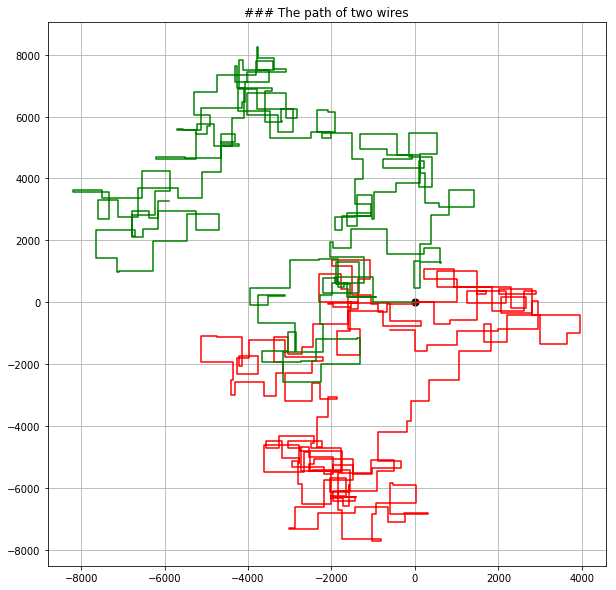

In [90]:
# Set the figure
plt.figure(figsize=(10,10))

# Converting wirepaths to cartesian form
wire_1_cart = np.array(to_cartesian(wire_1))
wire_2_cart = np.array(to_cartesian(wire_2))

# Plot the 2 paths
plt.scatter(0, 0, c='black', s = 50) # Show origin
plt.plot(wire_1_cart[:, 0], wire_1_cart[:, 1], c = 'r')
plt.plot(wire_2_cart[:, 0], wire_2_cart[:, 1], c = 'g')
plt.grid(True)
plt.title("### The path of two wires")
plt.show()

In [91]:
# Find the set of intersection points
crosses = np.array(find_crosses(wire_1_cart, wire_2_cart))

# Find nearest intersection point to the origin
nearest_index = 1
nearest = Manhattan(crosses[1])
dist = 0
for i in range(2, len(crosses)):
    dist = Manhattan(crosses[i])
    if dist < nearest:
        nearest = dist
        nearest_index = i
        
print(nearest_index, nearest, crosses[nearest_index], len(crosses))

40 1225 [-1059   166] 41


### The other way

In [92]:

# As they are right now, the variables 'wire_i_cart' only contain the corners of the wire's path, 
# i.e. the points at which the wire changes direction. This implies that intersection points 
# never explicitly appear in those variables because they occur in between those points.

# Another way to solve the problem would then be to PAD the various paths so that they contain ALL the points
# by which the wire passes. For example instead of being [...[50, 3], [46, 3], ...] the variable will
# store [...[50, 3], [49, 3], [48, 3], [47, 3], [46, 3], ...]. 
# Obviously, note how by 'all the points' we actually mean all the ones on the integer grid, but they are 
# enough for this context in which everything is running on integers.

# Before proceding however, we stress that this operation will, given the numbers we are dealing with, 
# enlarge the dimension of the wire_i_cart variables quite a few, in fact if we calculate the total length
# of the paths, we will know exactly how many points will the variable store. These are:

print(wire_length(wire_1_cart), " compared to the actual ", len(wire_1_cart))
print("and")
print(wire_length(wire_2_cart), " compared to the actual ", len(wire_2_cart))

147638  compared to the actual  302
and
150424  compared to the actual  302


In [93]:
# With this in mind, the easiest way to proceed is to pad the initial set of instruction, since
# this can easily be done as
import re

# Function that fills instruction lists into its atomic instructions
def fill_instruction_list(instr_list):
    
    filled = []
    
    for instruction in instr_list:
        direction = re.findall('[A-Z]', instruction)[0]
        value = int(re.findall('[0-9]+', instruction)[0])
    
        for i in range(value):
            # Move 1 step in the specified direction
            filled.append(direction+'1')
    
    return filled

# Function that creates a unique hash string from a pair of cartesia points as:
# (12, 34) --> x12y34
def cartesian_hash(cart_list, option = 0):

    hashed = []
    
    if option == 'r':
        
        for item in cart_list:
            elem = list(item.replace('x', '').split('y'))
            int_pair = [int(x) for x in elem]
            hashed.append(int_pair)
    else:
        
        for item in cart_list:
            elem = 'x'+str(item[0])+'y'+str(item[1])
            hashed.append(elem)
    
    return hashed
    

In [94]:
# Writing the extended instruction paths in cartesian form           
wire_1_ext = to_cartesian(fill_instruction_list(wire_1))
wire_2_ext = to_cartesian(fill_instruction_list(wire_2))

In [95]:
# Now finding the intersection points should be as easy as doing a nested 'for' loop that search for points
# which appeaer in both lists, or even better using 'x in list' construct. However, given the sizes of the 
# two lists (see before), this comparsion would be very time consuming!

# Fortunately we can convert the lists to SETS, using the set() method. The advantage of sets is that the 
# operations of are faster. The disadvantage is that element are not indexed in a set, so if we care about
# the index, this must be find in another way. For now we only need the common points, i.e. the intersection 
# of the two sets. 
# Before converting our lists to sets however we must make the elements of the lists hashable, 
# so we must convert the pair [X, Y] into an hashable such as a string. This conversion is given by the
# hash_list method implemented above.

# Initialize the two sets
wire_1_set = set(cartesian_hash(wire_1_ext))
wire_2_set = set(cartesian_hash(wire_2_ext))


In [96]:
# Find the common points to the two sets: these are the intersection of the wires

set_crosses = []

for point in set_1:
    if point in set_2:
        set_crosses.append(point)
    
# We must also convert back to the cartesian form from the hashed form
new_crosses = cartesian_hash(set_crosses, 'r')

In [97]:
# Again, we can find now the nearest point to the central port as
new_crosses = np.array(new_crosses)

nearest_index = 1
nearest = Manhattan(crosses[1])

for i in range(2, len(crosses)):
    dist = Manhattan(crosses[i])
    if dist < nearest:
        nearest = dist
        nearest_index = i
        
print(nearest_index, nearest, crosses[nearest_index], len(crosses))

40 1225 [-1059   166] 41
